<a href="https://colab.research.google.com/github/chaitanyavaleti/SolarPannel_DefectDetection/blob/main/Solar_pannel_falt_detect.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import cv2

# Input (original images) and output (resized images) directories
input_dir = "/content/drive/MyDrive/SampleImages"
output_dir = "/content/drive/MyDrive/SampleImages-resized"
target_size = (224, 224)   # resize to 224x224 (for ResNet/EfficientNet)

# Create output directory if not exists
os.makedirs(output_dir, exist_ok=True)

# Walk through all subfolders (e.g., clean, dusty, bird-drop, etc.)
for root, dirs, files in os.walk(input_dir):
    # Figure out relative path
    rel_path = os.path.relpath(root, input_dir)
    save_path = os.path.join(output_dir, rel_path)
    os.makedirs(save_path, exist_ok=True)

    for file in files:
        if file.lower().endswith(('.png', '.jpg', '.jpeg')):
            img_path = os.path.join(root, file)
            save_img_path = os.path.join(save_path, file)

            # Read and resize
            img = cv2.imread(img_path)
            if img is None:
                continue  # skip broken files
            img_resized = cv2.resize(img, target_size)

            # Save resized image
            cv2.imwrite(save_img_path, img_resized)

print("✅ All images resized and saved to:", output_dir)

✅ All images resized and saved to: /content/drive/MyDrive/SampleImages-resized


In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf
import random
from cv2 import resize
from glob import glob

import warnings
warnings.filterwarnings("ignore")

In [2]:
img_height = 244
img_width = 244
train_ds = tf.keras.utils.image_dataset_from_directory(
  '/content/drive/MyDrive/SampleImages-resized',
  validation_split=0.2,
  subset='training',
  image_size=(img_height, img_width),
  batch_size=32,
  seed=42,
  shuffle=True)

val_ds = tf.keras.utils.image_dataset_from_directory(
  '/content/drive/MyDrive/SampleImages-resized',
  validation_split=0.2,
  subset='validation',
  image_size=(img_height, img_width),
  batch_size=32,
  seed=42,
  shuffle=True)

Found 379 files belonging to 6 classes.
Using 304 files for training.
Found 379 files belonging to 6 classes.
Using 75 files for validation.


In [3]:
class_names = train_ds.class_names
print(class_names)
train_ds

['Bird-drop', 'Clean', 'Dusty', 'Electrical-damage', 'Physical-Damage', 'Snow-Covered']


<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 244, 244, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

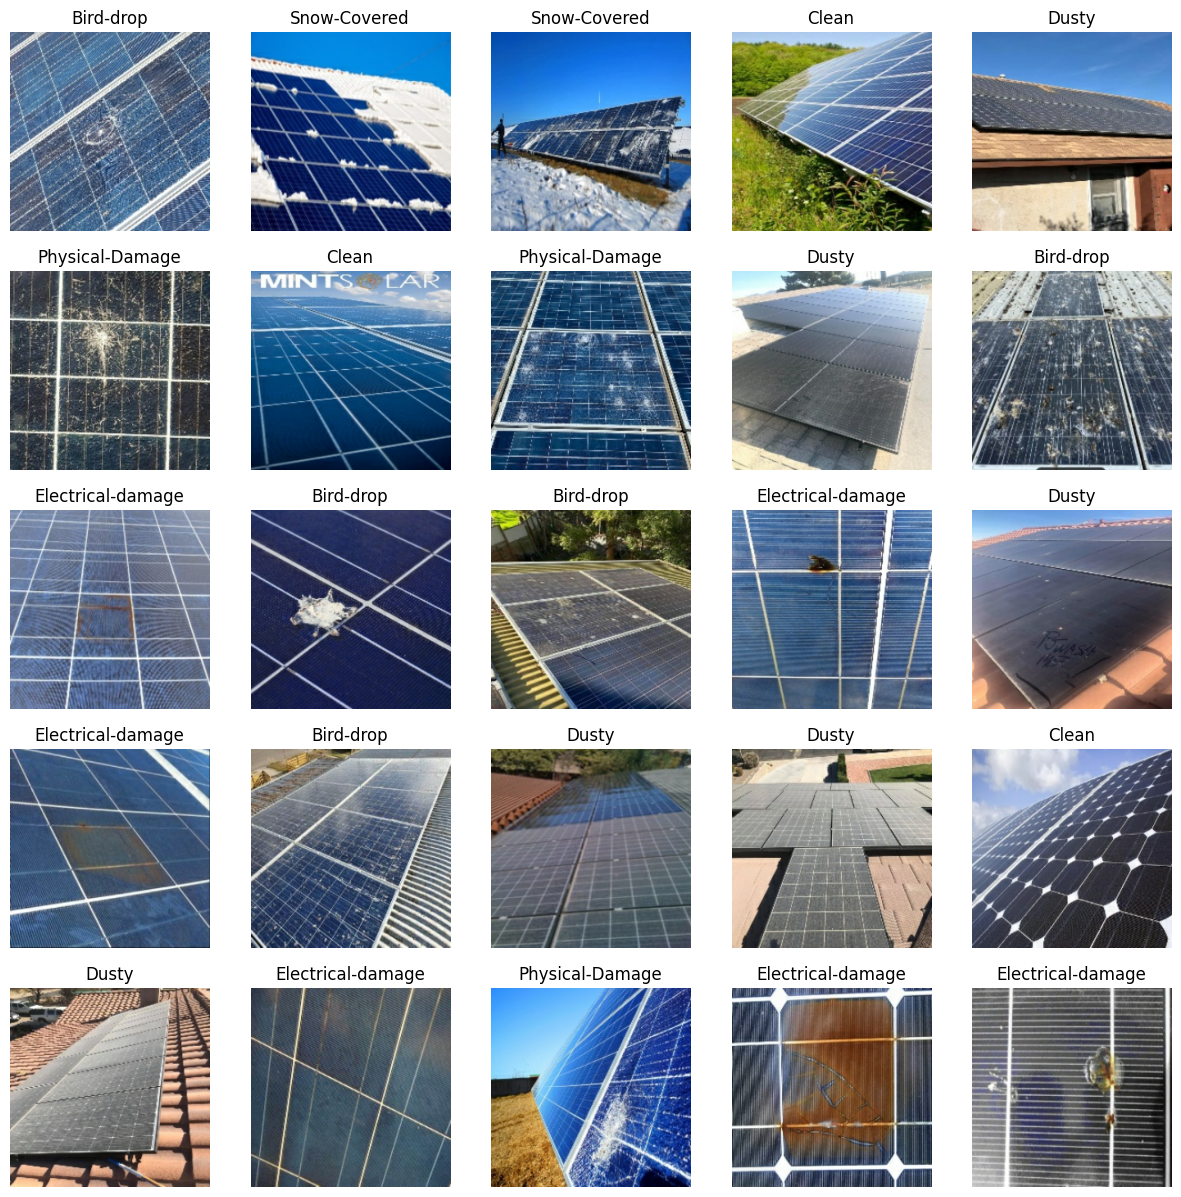

In [4]:
plt.figure(figsize=(15, 15))
for images, labels in train_ds.take(1):
    for i in range(25):
        ax = plt.subplot(5, 5, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [5]:
base_model = tf.keras.applications.VGG16(
    include_top=False,
    weights='imagenet',
    input_shape=(img_height, img_width, 3)
)
base_model.trainable = False

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [6]:
inputs = tf.keras.Input(shape=(img_height, img_width, 3))
x = tf.keras.applications.vgg16.preprocess_input(inputs)
x = base_model(x, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.3)(x)
outputs = tf.keras.layers.Dense(90)(x)
model = tf.keras.Model(inputs, outputs)

model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 244, 244,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item (GetItem)  │ (None, 244, 244)  │          0 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_1          │ (None, 244, 244)  │          0 │ input_layer_1[0]… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_2          │ (None, 244, 244)  │          0 │ input_layer_1[0]… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stack (Stack)       │ (None, 244, 244,  │          0 │ get_item[0][0],   │
│                     │ 3)                │            │ get_item_1[0][0], │
│                     │                   │            │ get_item_2[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 244, 244,  │          0 │ stack[0][0]       │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ vgg16 (Functional)  │ (None, 7, 7, 512) │ 14,714,688 │ add[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 512)       │          0 │ vgg16[0][0]       │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 512)       │          0 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 90)        │     46,170 │ dropout[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 14,760,858 (56.31 MB)

 Trainable params: 46,170 (180.35 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [8]:
pip install pydot


In [10]:
pip install visualkeras


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 13.3 MB/s eta 0:00:00


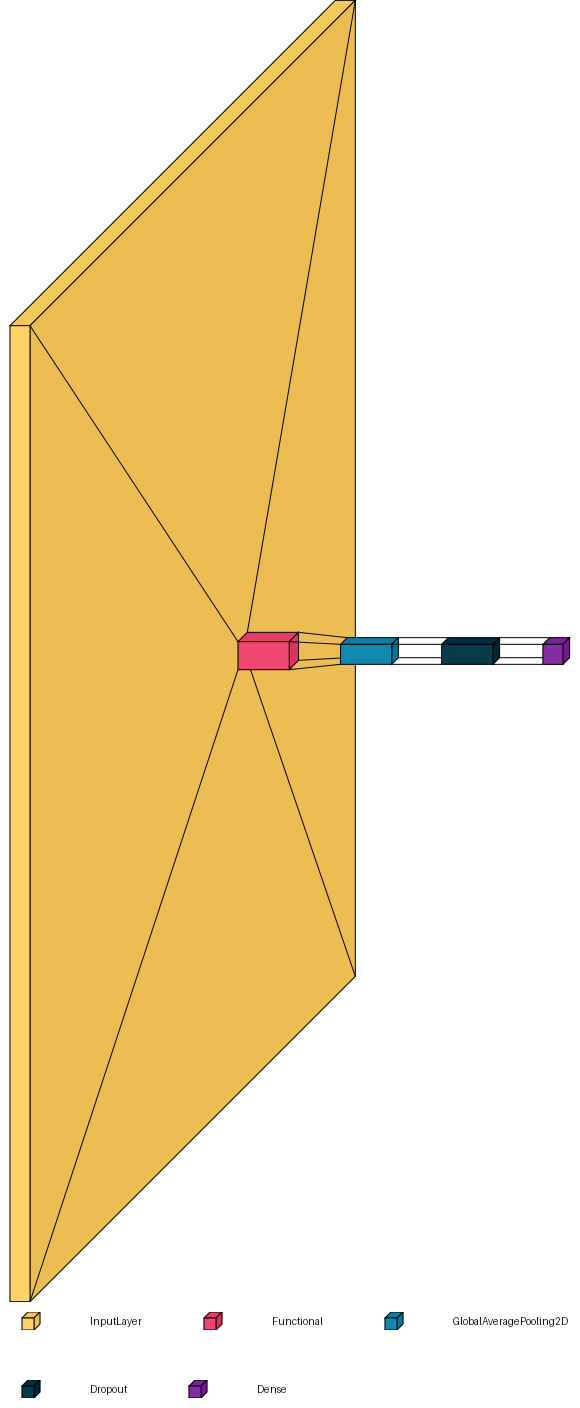

In [11]:
import visualkeras
visualkeras.layered_view(model,legend=True,spacing=50,background_fill = 'white')

In [12]:
model.compile(optimizer=tf.keras.optimizers.Adam(0.001),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

epoch = 15
model.fit(train_ds, validation_data=val_ds, epochs=epoch,
    callbacks = [
        tf.keras.callbacks.EarlyStopping(
            monitor="val_loss",
            min_delta=1e-2,
            patience=3,
            verbose=1,
            restore_best_weights=True
        )
    ]
)

Epoch 1/15
10/10 ━━━━━━━━━━━━━━━━━━━━ 324s 32s/step - accuracy: 0.0656 - loss: 9.7969 - val_accuracy: 0.2133 - val_loss: 4.3152
Epoch 2/15
10/10 ━━━━━━━━━━━━━━━━━━━━ 311s 32s/step - accuracy: 0.2620 - loss: 5.1470 - val_accuracy: 0.2933 - val_loss: 3.3171
Epoch 3/15
10/10 ━━━━━━━━━━━━━━━━━━━━ 285s 29s/step - accuracy: 0.2802 - loss: 4.1739 - val_accuracy: 0.4133 - val_loss: 2.7606
Epoch 4/15
10/10 ━━━━━━━━━━━━━━━━━━━━ 282s 29s/step - accuracy: 0.3958 - loss: 3.2049 - val_accuracy: 0.4400 - val_loss: 2.4478
Epoch 5/15
10/10 ━━━━━━━━━━━━━━━━━━━━ 313s 32s/step - accuracy: 0.4598 - loss: 2.6844 - val_accuracy: 0.5067 - val_loss: 2.1575
Epoch 6/15
10/10 ━━━━━━━━━━━━━━━━━━━━ 317s 31s/step - accuracy: 0.4786 - loss: 2.4963 - val_accuracy: 0.5467 - val_loss: 1.9676
Epoch 7/15
10/10 ━━━━━━━━━━━━━━━━━━━━ 310s 32s/step - accuracy: 0.4915 - loss: 2.4593 - val_accuracy: 0.5867 - val_loss: 1.8010
Epoch 8/15
10/10 ━━━━━━━━━━━━━━━━━━━━ 289s 30s/step - accuracy: 0.5499 - loss: 1.8865 - val_accuracy: 0.

In [20]:
#fine tuning
base_model.trainable = True
for layer in base_model.layers[:14]:
    layer.trainable = False
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 244, 244,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item (GetItem)  │ (None, 244, 244)  │          0 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_1          │ (None, 244, 244)  │          0 │ input_layer_1[0]… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_2          │ (None, 244, 244)  │          0 │ input_layer_1[0]… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stack (Stack)       │ (None, 244, 244,  │          0 │ get_item[0][0],   │
│                     │ 3)                │            │ get_item_1[0][0], │
│                     │                   │            │ get_item_2[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 244, 244,  │          0 │ stack[0][0]       │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ vgg16 (Functional)  │ (None, 7, 7, 512) │ 14,714,688 │ add[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 512)       │          0 │ vgg16[0][0]       │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 512)       │          0 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 90)        │     46,170 │ dropout[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 14,853,200 (56.66 MB)

 Trainable params: 7,125,594 (27.18 MB)

 Non-trainable params: 7,635,264 (29.13 MB)

 Optimizer params: 92,342 (360.71 KB)

In [21]:
model.compile(optimizer=tf.keras.optimizers.Adam(0.0001),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [22]:
epoch = 15
history = model.fit(train_ds, validation_data=val_ds, epochs=epoch,
    callbacks = [
        tf.keras.callbacks.EarlyStopping(
            monitor="val_loss",
            min_delta=1e-2,
            patience=3,
            verbose=1,
            restore_best_weights=True
        )
    ]
)

Epoch 1/15
10/10 ━━━━━━━━━━━━━━━━━━━━ 337s 34s/step - accuracy: 0.6478 - loss: 1.3765 - val_accuracy: 0.7067 - val_loss: 1.2305
Epoch 2/15
10/10 ━━━━━━━━━━━━━━━━━━━━ 369s 38s/step - accuracy: 0.8015 - loss: 0.5729 - val_accuracy: 0.7600 - val_loss: 0.9478
Epoch 3/15
10/10 ━━━━━━━━━━━━━━━━━━━━ 369s 36s/step - accuracy: 0.9015 - loss: 0.4380 - val_accuracy: 0.7333 - val_loss: 0.8264
Epoch 4/15
10/10 ━━━━━━━━━━━━━━━━━━━━ 358s 36s/step - accuracy: 0.9400 - loss: 0.1720 - val_accuracy: 0.7467 - val_loss: 1.0246
Epoch 5/15
10/10 ━━━━━━━━━━━━━━━━━━━━ 357s 34s/step - accuracy: 0.9474 - loss: 0.1206 - val_accuracy: 0.8133 - val_loss: 0.7239
Epoch 6/15
10/10 ━━━━━━━━━━━━━━━━━━━━ 412s 37s/step - accuracy: 0.9885 - loss: 0.0363 - val_accuracy: 0.7733 - val_loss: 0.6351
Epoch 7/15
10/10 ━━━━━━━━━━━━━━━━━━━━ 378s 37s/step - accuracy: 0.9913 - loss: 0.0276 - val_accuracy: 0.7867 - val_loss: 0.7361
Epoch 8/15
10/10 ━━━━━━━━━━━━━━━━━━━━ 334s 34s/step - accuracy: 0.9783 - loss: 0.0457 - val_accuracy: 0.

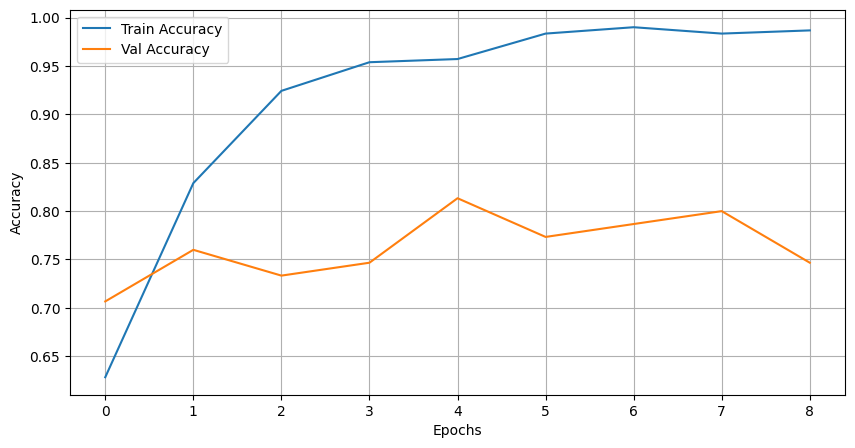

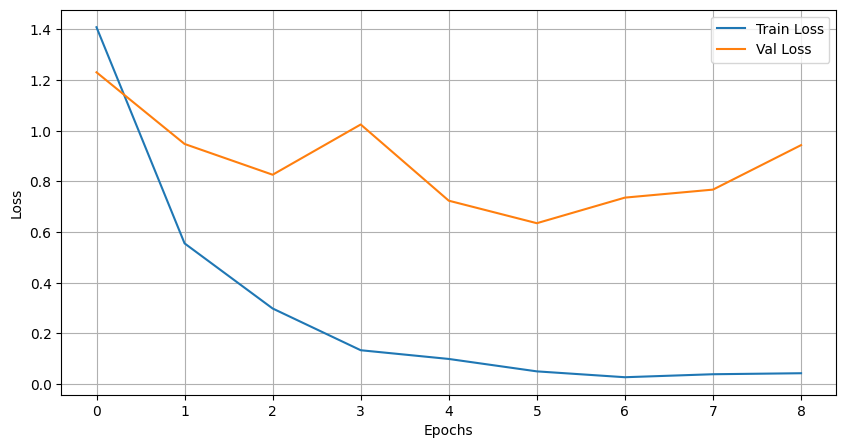

In [23]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10,5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


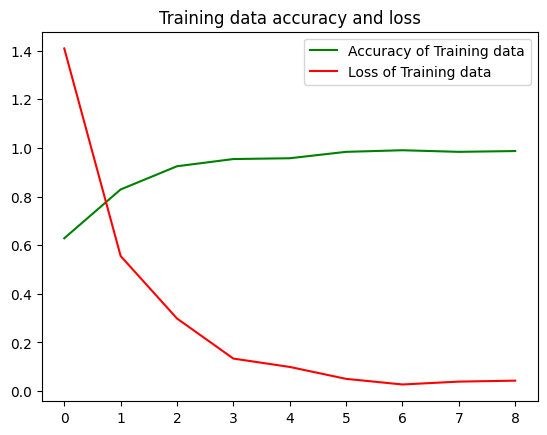

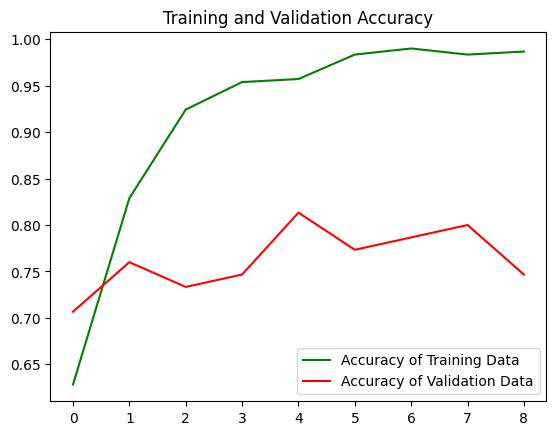

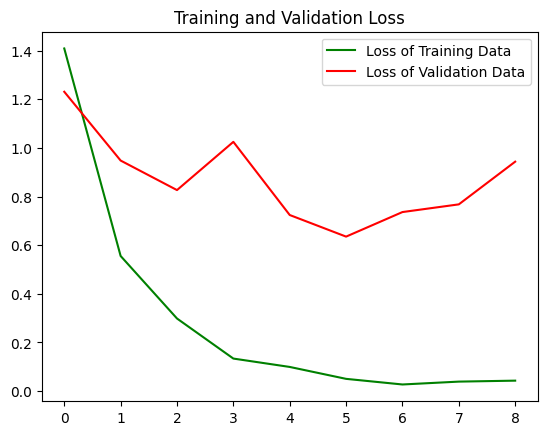

<Figure size 640x480 with 0 Axes>

In [24]:
get_ac = history.history['accuracy']
get_los = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']

epochs = range(len(get_ac))
plt.plot(epochs, get_ac, 'g', label='Accuracy of Training data')
plt.plot(epochs, get_los, 'r', label='Loss of Training data')
plt.title('Training data accuracy and loss')
plt.legend(loc=0)
plt.figure()

plt.plot(epochs, get_ac, 'g', label='Accuracy of Training Data')
plt.plot(epochs, val_acc, 'r', label='Accuracy of Validation Data')
plt.title('Training and Validation Accuracy')
plt.legend(loc=0)
plt.figure()

plt.plot(epochs, get_los, 'g', label='Loss of Training Data')
plt.plot(epochs, val_loss, 'r', label='Loss of Validation Data')
plt.title('Training and Validation Loss')
plt.legend(loc=0)
plt.figure()
plt.show()

In [31]:
model.save("solar_panel_condition_model.keras")
from tensorflow.keras.models import load_model
model = load_model("/content/solar_panel_condition_model.keras")
test_loss, test_acc = model.evaluate(val_ds)
print(f"Test accuracy: {test_acc*100:.2f}%")

6/6 ━━━━━━━━━━━━━━━━━━━━ 141s 22s/step - accuracy: 0.7698 - loss: 1.0508
Test accuracy: 76.88%


In [32]:
model.save("solar_panel_condition_model_train.keras")
from tensorflow.keras.models import load_model
model_train = load_model("/content/solar_panel_condition_model_train.keras")
train_loss, train_acc = model.evaluate(train_ds)
print(f"Train accuracy: {test_acc*100:.2f}%")

22/22 ━━━━━━━━━━━━━━━━━━━━ 527s 24s/step - accuracy: 0.7630 - loss: 1.3250
Test accuracy: 76.88%


In [ ]:
oss, accuracy = model.evaluate(val_ds)

plt.figure(figsize=(20, 20))
for images, labels in val_ds.take(1):
    for i in range(16):
        ax = plt.subplot(4, 4, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        predictions = model.predict(tf.expand_dims(images[i], 0))
        score = tf.nn.softmax(predictions[0])
        if(class_names[labels[i]]==class_names[np.argmax(score)]):
            plt.title("Actual: "+class_names[labels[i]])
            plt.ylabel("Predicted: "+class_names[np.argmax(score)],fontdict={'color':'green'})

        else:
            plt.title("Actual: "+class_names[labels[i]])
            plt.ylabel("Predicted: "+class_names[np.argmax(score)],fontdict={'color':'red'})
        plt.gca().axes.yaxis.set_ticklabels([])
        plt.gca().axes.xaxis.set_ticklabels([])

## Without Augumentation




In [29]:
import os
import cv2

# Input (original images) and output (resized images) directories
input_dir = "/content/drive/MyDrive/SampleImages"
output_dir = "/content/drive/MyDrive/TestImages-resized"
target_size = (224, 224)   # resize to 224x224 (for ResNet/EfficientNet)

# Create output directory if not exists
os.makedirs(output_dir, exist_ok=True)

# Walk through all subfolders (e.g., clean, dusty, bird-drop, etc.)
for root, dirs, files in os.walk(input_dir):
    # Figure out relative path
    rel_path = os.path.relpath(root, input_dir)
    save_path = os.path.join(output_dir, rel_path)
    os.makedirs(save_path, exist_ok=True)

    for file in files:
        if file.lower().endswith(('.png', '.jpg', '.jpeg')):
            img_path = os.path.join(root, file)
            save_img_path = os.path.join(save_path, file)

            # Read and resize
            img = cv2.imread(img_path)
            if img is None:
                continue  # skip broken files
            img_resized = cv2.resize(img, target_size)

            # Save resized image
            cv2.imwrite(save_img_path, img_resized)

print("✅ All images resized and saved to:", output_dir)

✅ All images resized and saved to: /content/drive/MyDrive/TestImages-resized


In [30]:
img_height = 244
img_width = 244
train_ds = tf.keras.utils.image_dataset_from_directory(
  '/content/drive/MyDrive/TestImages-resized',
  validation_split=0.2,
  subset='training',
  image_size=(img_height, img_width),
  batch_size=32,
  seed=42,
  shuffle=True)

val_ds = tf.keras.utils.image_dataset_from_directory(
  '/content/drive/MyDrive/TestImages-resized',
  validation_split=0.2,
  subset='validation',
  image_size=(img_height, img_width),
  batch_size=32,
  seed=42,
  shuffle=True)

Found 869 files belonging to 6 classes.
Using 696 files for training.
Found 869 files belonging to 6 classes.
Using 173 files for validation.
